In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

## SRTT

/tmp/ipykernel_801149/4077286059.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cumulative_df[f'{service}_cumulative'] = df[columns].fillna(0).sum(axis=1)
/tmp/ipykernel_801149/4077286059.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cumulative_df[f'{service}_cumulative'] = df[columns].fillna(0).sum(axis=1)
/tmp/ipykernel_801149/4077286059.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colu

Available cumulative metrics: ['localhost_cumulative', 'api_gateway_cumulative', 'vets_service_cumulative', 'discovery_cumulative', 'customers_service_cumulative', 'visits_service_cumulative', 'genai_service_cumulative', 'customers_service_server2_inf_cumulative', 'customers_service_server2_1000_cumulative', 'customers_service_server2_10000_cumulative', 'customers_service_server2_100000_cumulative', 'customers_service_server2_1000000_cumulative', 'customers_service_server2_10000000_cumulative', 'visits_service_server2_inf_cumulative', 'visits_service_server2_1000_cumulative', 'visits_service_server2_10000_cumulative', 'visits_service_server2_100000_cumulative', 'visits_service_server2_1000000_cumulative', 'visits_service_server2_10000000_cumulative', 'vets_service_server2_inf_cumulative', 'vets_service_server2_1000_cumulative', 'vets_service_server2_10000_cumulative', 'vets_service_server2_100000_cumulative', 'vets_service_server2_1000000_cumulative', 'vets_service_server2_10000000_cum

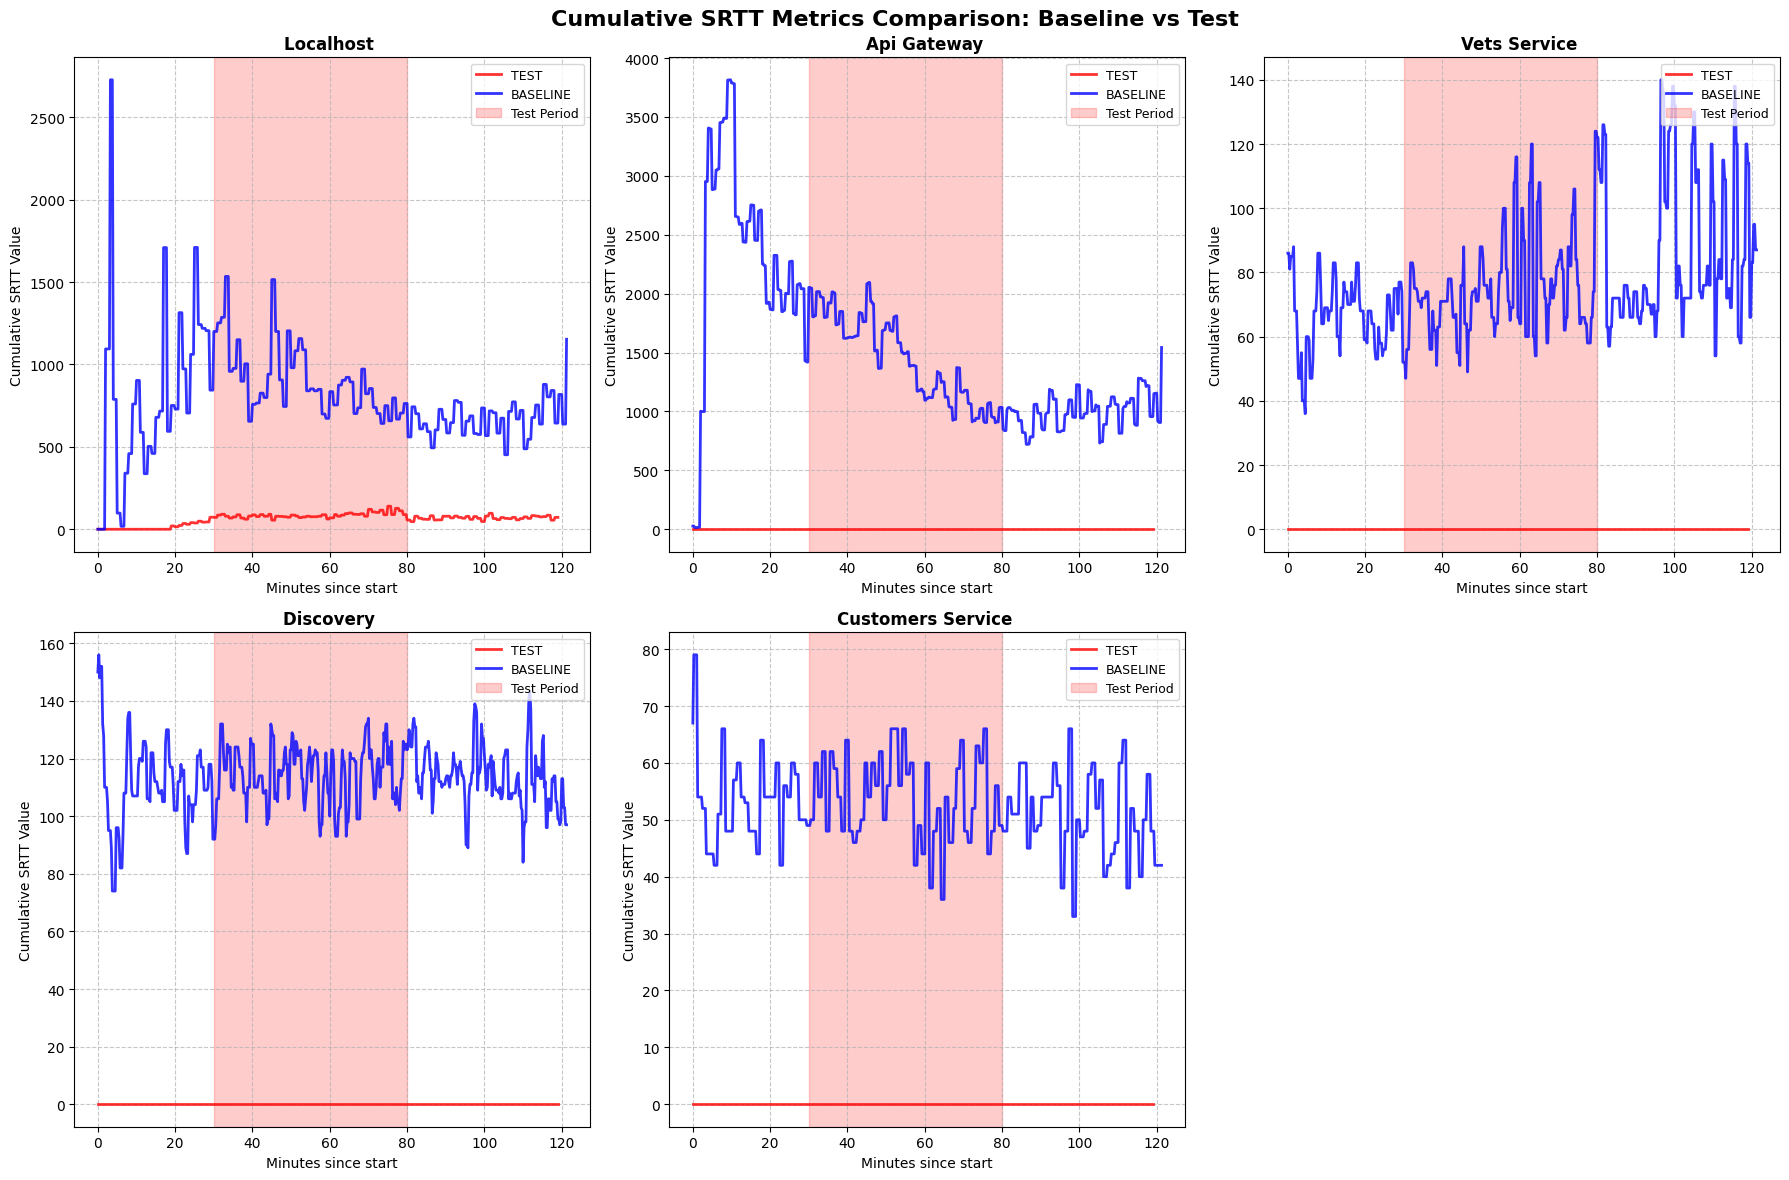

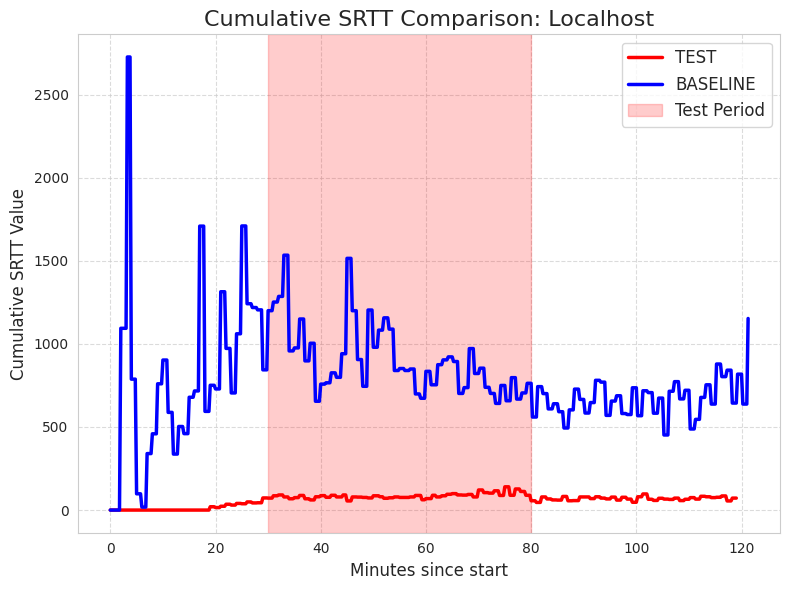

=== Cumulative SRTT Statistical Summary ===

Service: localhost
TEST Dataset - Mean: 62.12, Std: 33.08
BASELINE Dataset - Mean: 799.65, Std: 323.46
During Test Period (30-80 minutes):
TEST Dataset - Mean: 85.51
BASELINE Dataset - Mean: 905.84
Difference: -820.33 (-90.6% change)

Service: api_gateway
TEST Dataset - Mean: 0.00, Std: 0.00
BASELINE Dataset - Mean: 1510.21, Std: 718.46
During Test Period (30-80 minutes):
TEST Dataset - Mean: 0.00
BASELINE Dataset - Mean: 1447.13
Difference: -1447.13 (-100.0% change)

Service: vets_service
TEST Dataset - Mean: 0.00, Std: 0.00
BASELINE Dataset - Mean: 76.75, Std: 19.49
During Test Period (30-80 minutes):
TEST Dataset - Mean: 0.00
BASELINE Dataset - Mean: 74.82
Difference: -74.82 (-100.0% change)

Service: discovery
TEST Dataset - Mean: 0.00, Std: 0.00
BASELINE Dataset - Mean: 113.37, Std: 11.74
During Test Period (30-80 minutes):
TEST Dataset - Mean: 0.00
BASELINE Dataset - Mean: 114.63
Difference: -114.63 (-100.0% change)

Service: customers

/tmp/ipykernel_801149/4077286059.py:99: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test_cumulative['total_system_srtt'] = df_test_cumulative[cumulative_metrics].sum(axis=1)
/tmp/ipykernel_801149/4077286059.py:100: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_baseline_cumulative['total_system_srtt'] = df_baseline_cumulative[cumulative_metrics].sum(axis=1)


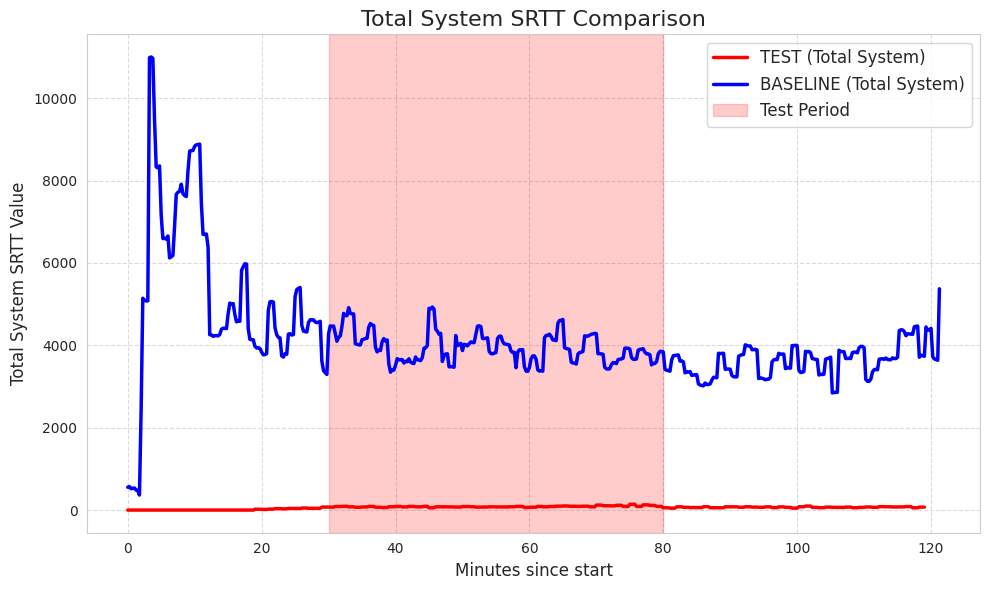

In [8]:
df_test = pd.read_csv("srtt.csv")
df_baseline = pd.read_csv("../../baseline/tcp related/srtt.csv")

df_test["source"] = "TEST"
df_baseline["source"] = "BASELINE"

df_test["Time"] = pd.to_datetime(df_test["Time"])
df_baseline["Time"] = pd.to_datetime(df_baseline["Time"])

df_test["Minutes"] = (df_test["Time"] - df_test["Time"].min()).dt.total_seconds() / 60
df_baseline["Minutes"] = (df_baseline["Time"] - df_baseline["Time"].min()).dt.total_seconds() / 60

delay = 30
duration = 50

def create_cumulative_metrics(df):
    metric_columns = [col for col in df.columns if col not in ['Time', 'source', 'Minutes']]
    service_groups = {}
    for col in metric_columns:
        if '_client_' in col or '_server_' in col:
            service_name = col.split('_client_')[0] if '_client_' in col else col.split('_server_')[0]
        else:
            service_name = col
        if service_name not in service_groups:
            service_groups[service_name] = []
        service_groups[service_name].append(col)
    cumulative_df = df[['Time', 'Minutes', 'source']].copy()
    for service, columns in service_groups.items():
        cumulative_df[f'{service}_cumulative'] = df[columns].fillna(0).sum(axis=1)
    return cumulative_df

df_test_cumulative = create_cumulative_metrics(df_test)
df_baseline_cumulative = create_cumulative_metrics(df_baseline)

cumulative_metrics = [col for col in df_test_cumulative.columns if col.endswith('_cumulative')]
key_cumulative_metrics = cumulative_metrics[:5]

print(f"Available cumulative metrics: {cumulative_metrics}")
print(f"Selected metrics for plotting: {key_cumulative_metrics}")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Cumulative SRTT Metrics Comparison: Baseline vs Test', fontsize=16, fontweight='bold')
axes_flat = axes.flatten()

for i, metric in enumerate(key_cumulative_metrics):
    if i < len(axes_flat):
        ax = axes_flat[i]
        ax.plot(df_test_cumulative["Minutes"], df_test_cumulative[metric], label="TEST", color='red', linewidth=2, alpha=0.8)
        ax.plot(df_baseline_cumulative["Minutes"], df_baseline_cumulative[metric], label="BASELINE", color='blue', linewidth=2, alpha=0.8)
        ax.axvspan(delay, delay + duration, color='red', alpha=0.2, label="Test Period")
        service_name = metric.replace('_cumulative', '').replace('_', ' ').title()
        ax.set_title(f'{service_name} ', fontsize=12, fontweight='bold')
        ax.set_xlabel("Minutes since start", fontsize=10)
        ax.set_ylabel("Cumulative SRTT Value", fontsize=10)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend(loc='upper right', fontsize=9)

for i in range(len(key_cumulative_metrics), len(axes_flat)):
    fig.delaxes(axes_flat[i])

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")

if key_cumulative_metrics:
    metric_focus = key_cumulative_metrics[0]
    plt.plot(df_test_cumulative["Minutes"], df_test_cumulative[metric_focus], label="TEST", color='red', linewidth=2.5)
    plt.plot(df_baseline_cumulative["Minutes"], df_baseline_cumulative[metric_focus], label="BASELINE", color='blue', linewidth=2.5)
    plt.axvspan(delay, delay + duration, color='red', alpha=0.2, label="Test Period")
    service_name = metric_focus.replace('_cumulative', '').replace('_', ' ').title()
    plt.title(f"Cumulative SRTT Comparison: {service_name}", fontsize=16)
    plt.xlabel("Minutes since start", fontsize=12)
    plt.ylabel("Cumulative SRTT Value", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='upper right', fontsize=12)
    plt.tight_layout()
    plt.show()

print("=== Cumulative SRTT Statistical Summary ===")
for metric in key_cumulative_metrics:
    service_name = metric.replace('_cumulative', '')
    print(f"\nService: {service_name}")
    print(f"TEST Dataset - Mean: {df_test_cumulative[metric].mean():.2f}, Std: {df_test_cumulative[metric].std():.2f}")
    print(f"BASELINE Dataset - Mean: {df_baseline_cumulative[metric].mean():.2f}, Std: {df_baseline_cumulative[metric].std():.2f}")
    test_period_test = df_test_cumulative[(df_test_cumulative["Minutes"] >= delay) & (df_test_cumulative["Minutes"] <= delay + duration)]
    test_period_baseline = df_baseline_cumulative[(df_baseline_cumulative["Minutes"] >= delay) & (df_baseline_cumulative["Minutes"] <= delay + duration)]
    if not test_period_test.empty and not test_period_baseline.empty:
        test_mean = test_period_test[metric].mean()
        baseline_mean = test_period_baseline[metric].mean()
        difference = test_mean - baseline_mean
        percentage_change = (difference / baseline_mean * 100) if baseline_mean != 0 else 0
        print(f"During Test Period ({delay}-{delay+duration} minutes):")
        print(f"TEST Dataset - Mean: {test_mean:.2f}")
        print(f"BASELINE Dataset - Mean: {baseline_mean:.2f}")
        print(f"Difference: {difference:.2f} ({percentage_change:.1f}% change)")

df_test_cumulative['total_system_srtt'] = df_test_cumulative[cumulative_metrics].sum(axis=1)
df_baseline_cumulative['total_system_srtt'] = df_baseline_cumulative[cumulative_metrics].sum(axis=1)

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
plt.plot(df_test_cumulative["Minutes"], df_test_cumulative['total_system_srtt'], label="TEST (Total System)", color='red', linewidth=2.5)
plt.plot(df_baseline_cumulative["Minutes"], df_baseline_cumulative['total_system_srtt'], label="BASELINE (Total System)", color='blue', linewidth=2.5)
plt.axvspan(delay, delay + duration, color='red', alpha=0.2, label="Test Period")
plt.title("Total System SRTT Comparison", fontsize=16)
plt.xlabel("Minutes since start", fontsize=12)
plt.ylabel("Total System SRTT Value", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper right', fontsize=12)
plt.tight_layout()
plt.show()


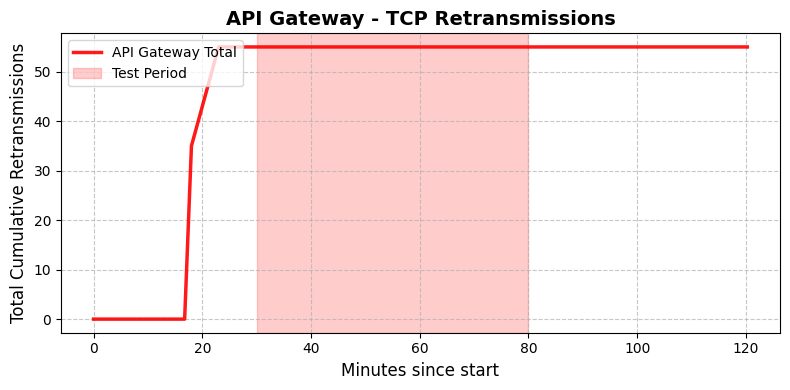

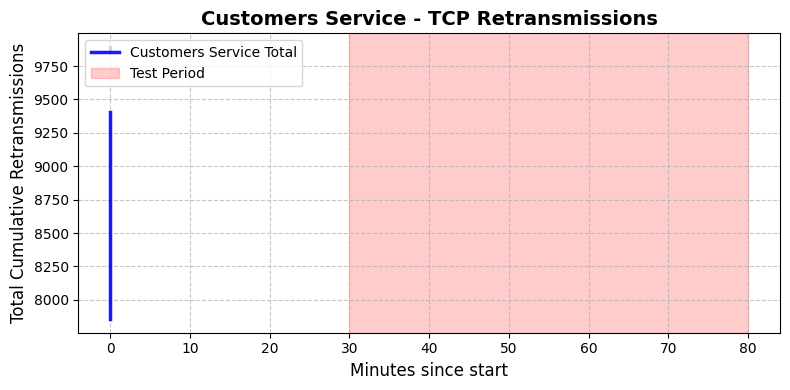

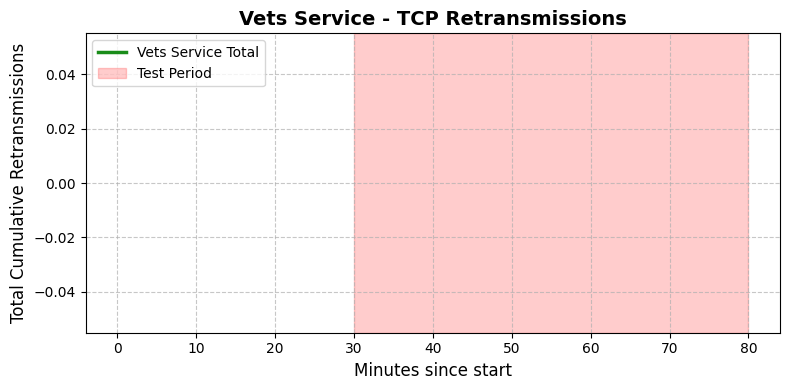

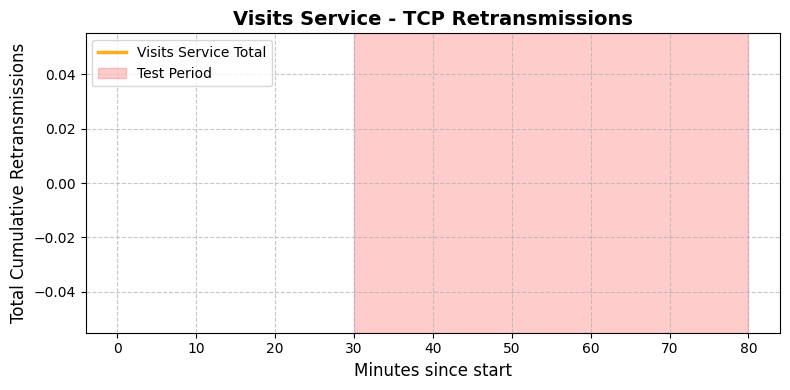

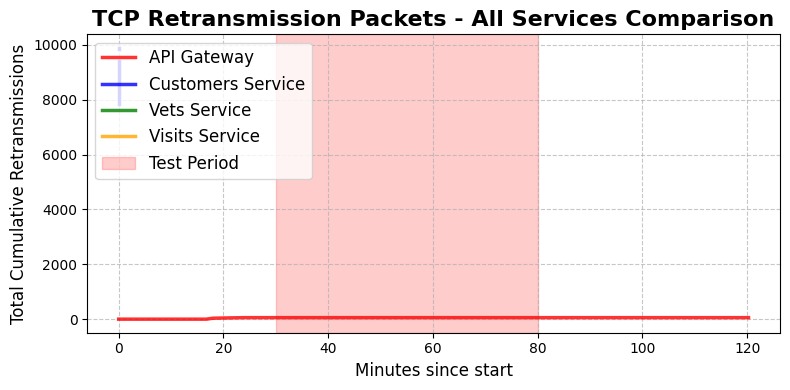

In [9]:
plt.style.use('default')
sns.set_palette("husl")

csv_files = [
    {'file': './retrans_packets/api_gateway.csv', 'name': 'API Gateway', 'color': 'red'},
    {'file': './retrans_packets/customers_service.csv', 'name': 'Customers Service', 'color': 'blue'}, 
    {'file': './retrans_packets/vets_service.csv', 'name': 'Vets Service', 'color': 'green'},
    {'file': './retrans_packets/visits_service.csv', 'name': 'Visits Service', 'color': 'orange'}
]


delay = 30  
duration = 50  

def load_and_process_csv(file_path, service_name):
    try:
        df = pd.read_csv(file_path)
        df["Time"] = pd.to_datetime(df["Time"])
        df["Minutes"] = (df["Time"] - df["Time"].min()).dt.total_seconds() / 60
        df["service"] = service_name
        
        return df
    except Exception as e:
        print(f"Errore nel caricamento di {file_path}: {e}")
        return None

def create_cumulative_metrics(df):
    connection_columns = [col for col in df.columns if col not in ['Time', 'Minutes', 'service']]
    cumulative_df = df[['Time', 'Minutes', 'service']].copy()
    
    for col in connection_columns:
        cumulative_df[f'{col}_cumulative'] = df[col].fillna(0).cumsum()
    
    cumulative_columns = [col for col in cumulative_df.columns if col.endswith('_cumulative')]
    cumulative_df['total_cumulative'] = cumulative_df[cumulative_columns].sum(axis=1)
    
    return cumulative_df

def plot_service_cumulative(df_cumulative, service_name, color):
    plt.figure(figsize=(8, 4))

    plt.plot(df_cumulative["Minutes"], df_cumulative['total_cumulative'], 
             color=color, linewidth=2.5, alpha=0.9, label=f'{service_name} Total')
    
    plt.axvspan(delay, delay + duration, color='red', alpha=0.2, label="Test Period")
    
    plt.title(f"{service_name} - TCP Retransmissions", fontsize=14, fontweight='bold')
    plt.xlabel("Minutes since start", fontsize=12)
    plt.ylabel("Total Cumulative Retransmissions", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='upper left', fontsize=10)
    plt.tight_layout()
    plt.show()


def plot_all_services_comparison(all_data):
    """Plotta il confronto tra tutti i servizi"""
    plt.figure(figsize=(8, 4))
    
    for service_data in all_data:
        df = service_data['df']
        plt.plot(df["Minutes"], df['total_cumulative'], 
                label=service_data['name'], 
                color=service_data['color'], 
                linewidth=2.5, alpha=0.8)
    
    plt.axvspan(delay, delay + duration, color='red', alpha=0.2, label="Test Period")
    
    plt.title("TCP Retransmission Packets - All Services Comparison", fontsize=16, fontweight='bold')
    plt.xlabel("Minutes since start", fontsize=12)
    plt.ylabel("Total Cumulative Retransmissions", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='upper left', fontsize=12)
    plt.tight_layout()
    plt.show()



def main():
    all_data = []
    for csv_info in csv_files:
        file_path = csv_info['file']
        df = load_and_process_csv(file_path, csv_info['name'])
        if df is not None:
            df_cumulative = create_cumulative_metrics(df)
            
            all_data.append({
                'df': df_cumulative,
                'name': csv_info['name'],
                'color': csv_info['color']
            })
            
    
    if not all_data:
        print("No CSV found")
        return
    
    for service_data in all_data:
        plot_service_cumulative(service_data['df'], service_data['name'], service_data['color'])
    if len(all_data) > 1:
        plot_all_services_comparison(all_data)
    
if __name__ == "__main__":
    main()